In [1]:
import tensorflow as tf

'2.9.0'

In [1]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
import tensorflow as tf

In [3]:
tf.version.VERSION

'2.6.0'

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [2]:
%store -r data_ready

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [3]:
#print(data_ready['category'].value_counts())
cat_index = data_ready['category'].value_counts().index

In [4]:
select_data = data_ready[data_ready['category'].isin(['hep-ph','hep-th','quant-ph'])].reset_index(drop=True)

#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(select_data["clean_text"], select_data["category"],
                                                    stratify = select_data["category"], test_size=0.2, shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

X_train.sort_indices()
X_test.sort_indices()

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y_train = encoder.transform(y_train)
encoded_y_test = encoder.transform(y_test)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = to_categorical(encoded_y_train)
dummy_y_test = to_categorical(encoded_y_test)

input_dim = X_train.shape[1]  # Number of features

In [18]:
def create_nn_model(dropout_rate=0.0, lam_l2=1e-3, learning_rate=1e-3, nlayers=5):
    # create model
    model = Sequential(name="Neural_network")
    for i in range(nlayers):
        model.add(layers.Dense(8*(nlayers-i), kernel_regularizer=l2(lam_l2), bias_regularizer=l2(lam_l2), input_dim=input_dim, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(3, activation='softmax'))
    optimizer = Adam(learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [7]:
# define the grid search parameters
#batch_size
cand_bs = [512, 1024, 2048]
#dropout rate
cand_dr = [0, 0.15, 0.3]
#regularization
cand_l2 = [0, 1e-3, 1e-1, 1]
#learning rate
cand_lr = [1e-4, 1e-3, 1e-2]
#layers number
cand_ln = [10, 5, 2, 1]

model = KerasClassifier(build_fn=create_model, epochs=10, verbose=0)

param_grid = dict(batch_size=cand_bs, dropout_rate=cand_dr, lam_l2=cand_l2, nlayers=cand_ln, learning_rate=cand_lr)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

Tune hyperparameters through cross-validation

In [ ]:
grid_result = grid.fit(X_train, dummy_y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [82]:
cv_results = pd.DataFrame.from_dict(grid_result.cv_results_).sort_values(by=['rank_test_score']).set_index('rank_test_score')
nn_cv_results0 = cv_results.drop(['std_fit_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 
                              'split2_test_score', 'split3_test_score', 'split4_test_score'], 1)
clist = list(nn_cv_results0.columns.values)
nn_cv_results0 = nn_cv_results0[clist[-2:] + clist[:-2]]
%store nn_cv_results0
nn_cv_results0

Stored 'nn_cv_results0' (DataFrame)


,mean_test_score,std_test_score,mean_fit_time,mean_score_time,param_batch_size,param_dropout_rate,param_lam_l2,param_learning_rate,param_nlayers
rank_test_score,,,,,,,,,
1,0.949328,0.000889,84.785579,1.89908,1024,0.15,0.001,0.001,5


Summarizing results

Training the best model on the whole training set

In [19]:
clear_session()

model = create_nn_model(dropout_rate=0.3, lam_l2=1e-3, learning_rate=1e-3, nlayers=5)
model.summary()

Model: "Neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                1874920   
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1312      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                792       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)             

In [20]:
history = model.fit(X_train, dummy_y_train, epochs=5, verbose=True, validation_data=(X_test, dummy_y_test),
                    batch_size=4096)

Epoch 1/5
27/27 [==============================] - 3s 74ms/step - loss: 1.2049 - accuracy: 0.3731 - val_loss: 1.0694 - val_accuracy: 0.3768
Epoch 2/5
27/27 [==============================] - 2s 61ms/step - loss: 1.0604 - accuracy: 0.4543 - val_loss: 0.8181 - val_accuracy: 0.9227
Epoch 3/5
27/27 [==============================] - 2s 61ms/step - loss: 0.8803 - accuracy: 0.7241 - val_loss: 0.6700 - val_accuracy: 0.9176
Epoch 4/5
27/27 [==============================] - 2s 63ms/step - loss: 0.7447 - accuracy: 0.8406 - val_loss: 0.5831 - val_accuracy: 0.9364
Epoch 5/5
27/27 [==============================] - 2s 65ms/step - loss: 0.6690 - accuracy: 0.8975 - val_loss: 0.5524 - val_accuracy: 0.9426


In [23]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9525
Testing Accuracy:  0.9426


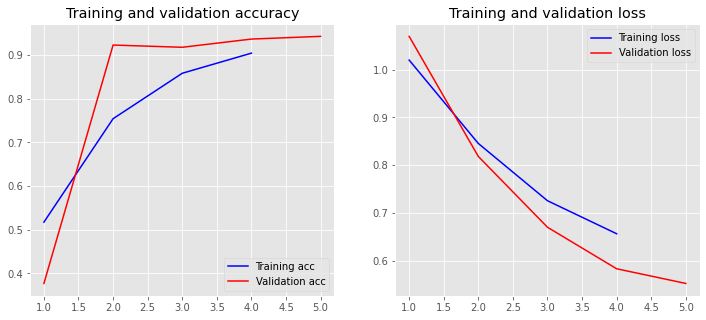

In [24]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x[:-1], acc[1:], 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x[:-1], loss[1:], 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

In [30]:
test_predicted_prob = model.predict(X_test)
test_predicted_classes = test_predicted_prob.argmax(1)

In [35]:
print("Each row corresponds to a true class, each columns corresponds to a predicted class.")
print("\n")
print(confusion_matrix(encoded_y_test, test_predicted_classes, normalize = 'true'))

Each row corresponds to a true class, each columns corresponds to a predicted class.


[[0.9446695  0.04762375 0.00770675]
 [0.04396309 0.93168418 0.02435273]
 [0.01600269 0.0341316  0.94986571]]
